In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set()
%matplotlib inline

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
# 查看销售价格数据描述
train_data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

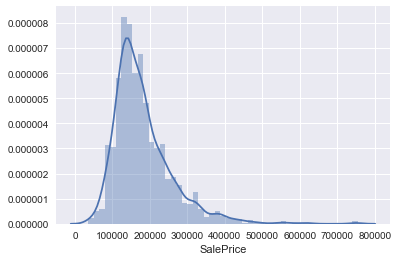

In [4]:
# 绘制直方图
sns.distplot(train_data['SalePrice'])

In [5]:
# 可以看到房价数据偏离正态分布，左偏

# 数据偏离度和峰度度量
print('Skewness:%f' % train_data['SalePrice'].skew()) # 偏度
print('Kurtosis:%f' % train_data['SalePrice'].kurt()) # 峰度

Skewness:1.882876
Kurtosis:6.536282


### <font color=blue>主观分析，查看字段含义后选出几个个人觉得比较主要的特征进行分析</font>

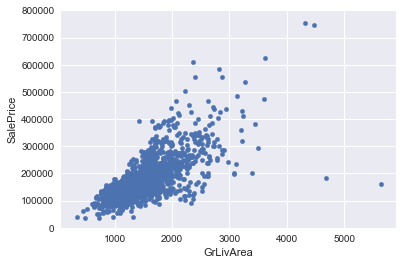

In [6]:
# 这里对于较重要的四个特征进行分析

# Grlivarea与SalePrice散点图（数字变量，散点图）
data = pd.concat([train_data['SalePrice'], train_data['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0, 800000)) # 由之前销售价格数据描述可知房价最高不超过80万

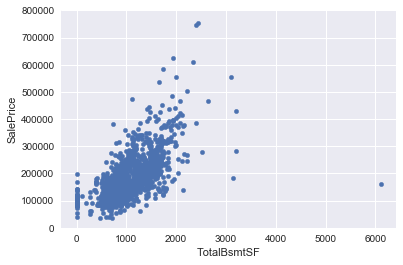

In [7]:
# 可以看到Grlivarea与SalePrice呈线性关系

# TotalBsmtSF与SalePrice散点图（数字变量，散点图）
data = pd.concat([train_data['SalePrice'], train_data['TotalBsmtSF']], axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice', ylim=(0, 800000))

(-0.5, 9.5, 0, 800000)

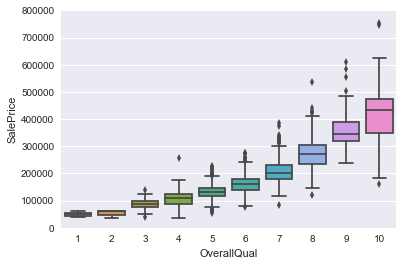

In [8]:
# 可以看到TotalBsmtSF与SalePrice呈线性关系，并且在特定关系下可以看到TotalBsmtSF对SalePrice没有影响

# OverallQual与SalePrice箱型图（类别变量，箱型图）
fig = sns.boxplot(x='OverallQual', y='SalePrice', data=train_data)
fig.axis(ymin=0, ymax=800000)

(-0.5, 111.5, 0, 800000)

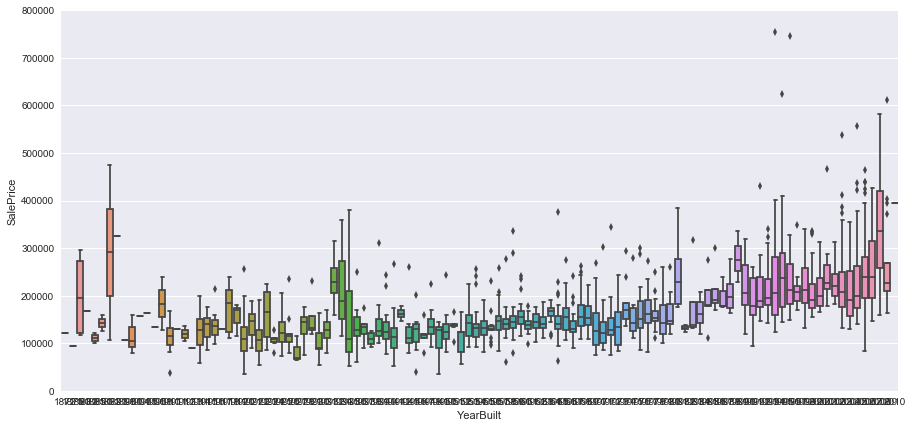

In [9]:
# 可以看出SalePrice与OverallQual分布趋势相同

# YearBuilt与SalePrice箱型图（类别变量，箱型图）
plt.figure(figsize=(15, 7))
fig = sns.boxplot(x='YearBuilt', y='SalePrice', data=train_data)
fig.axis(ymin=0, ymax=800000)

In [10]:
# 两个变量之间的关系没有很强的趋势性，但是可以看出建筑时间较短的房屋价格更高

总结：  
1、GrLivArea和TotalBsmtSF与SalePrice似乎线性相关，并且都是正相关  
对于TotalBsmtSF线性关系的斜率十分的高  
2、OverallQual和YearBuilt与SalePrice也有关系  
OverallQual的相关性更强, 箱型图显示了随着整体质量的增长，房价的增长趋势

### <font color=blue>客观分析</font>

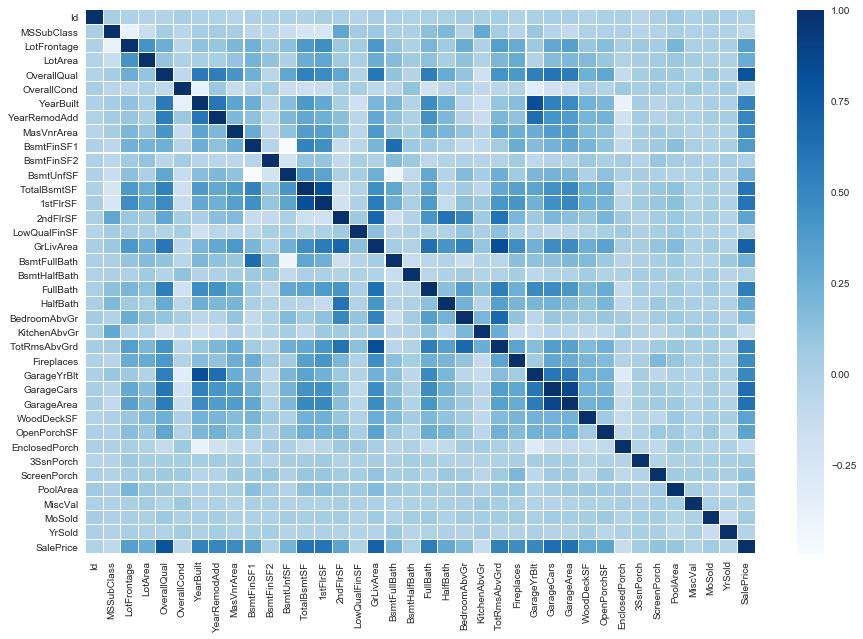

In [11]:
# 相关系数矩阵
corrmat = train_data.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corrmat, cmap='Blues', linewidths=0.1)

In [12]:
# 可以看到TotalBsmtSf和1stFlrSF的相关系数，GarageX特征群的相关系数很高，相关程度到达了一种多重共线性的情况，
# 总结出这些特征几乎包含相同的信息
# 另外，除了之前提到的四个特征，其他特征与SalePrice的相关性也很强

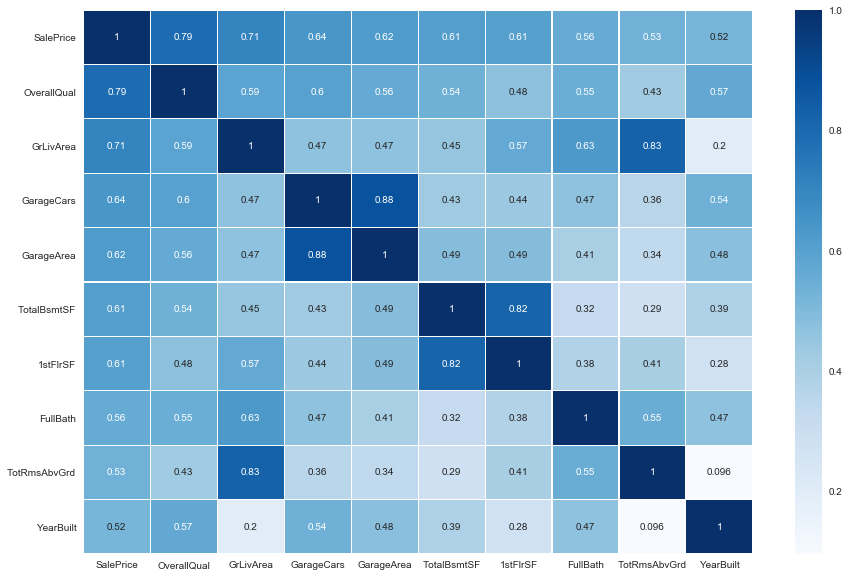

In [13]:
k = 10
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
corrmat2 = train_data[cols].corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corrmat2, cmap='Blues', linewidths=0.1, annot=True)

In [14]:
# 通过查看数据描述可以看到，GarageCars和GarageArea是相同维度的不同描述，可以去掉一个，这里可以选择与SalesPrice相关性更高的GarageCars
# 同理的，TotalBsmtSF和1stFloor只留下TotalBsmtSF即可

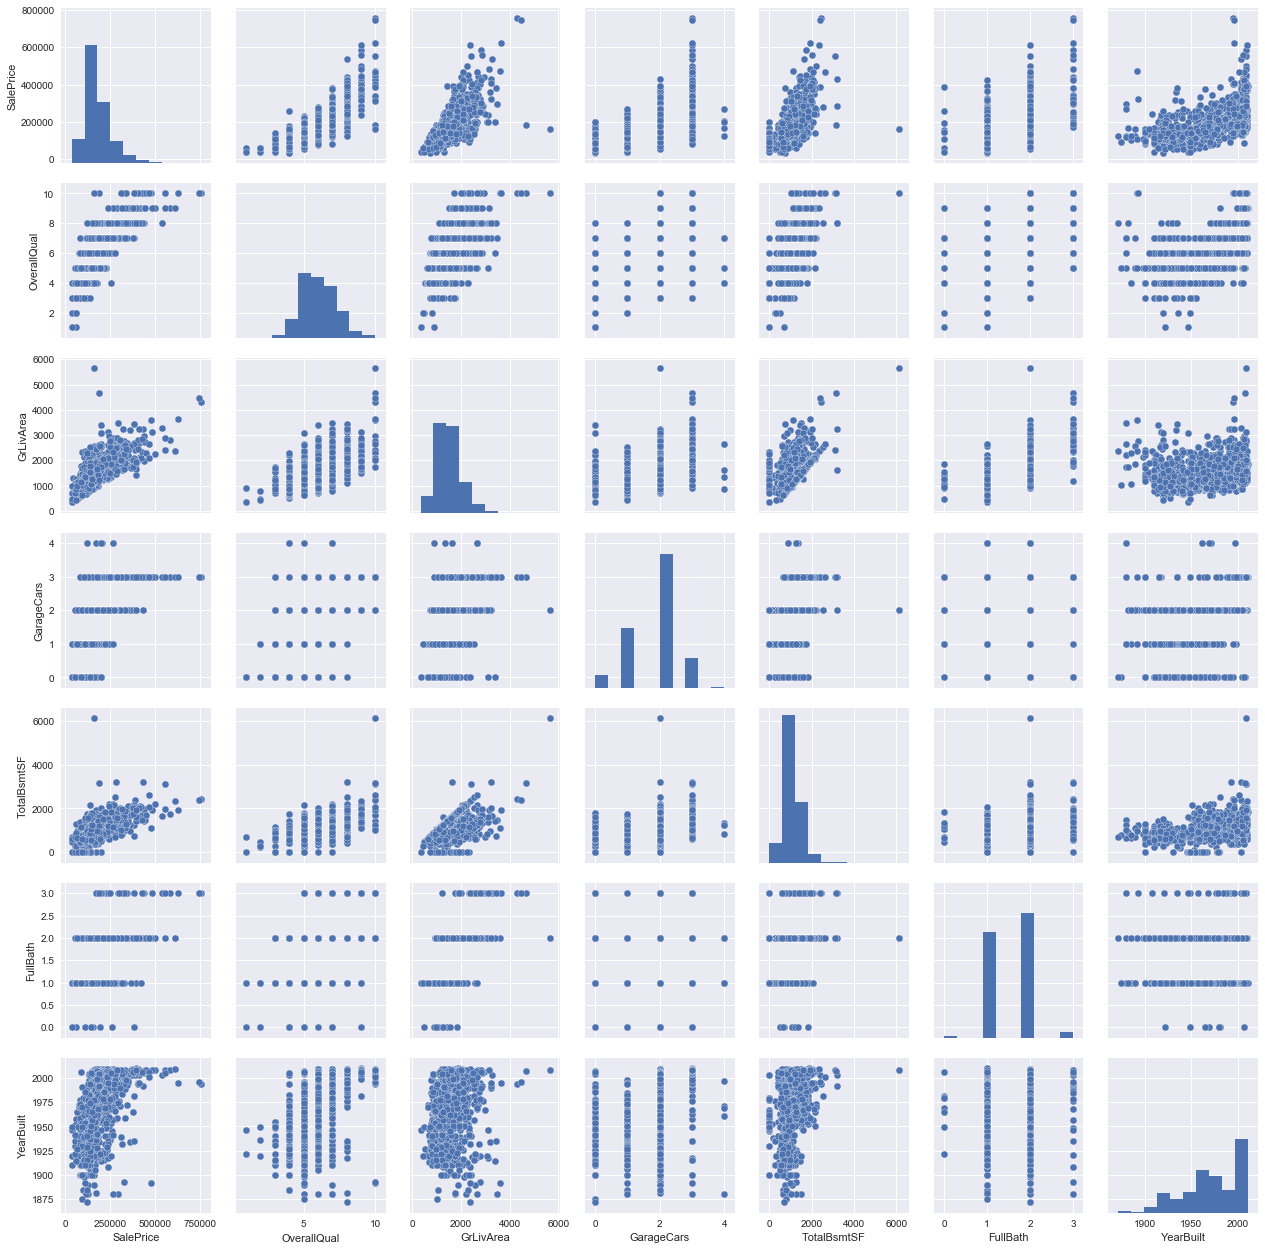

In [15]:
# 通过筛选之后，只留下7个特征，做出这些特征的多变量图
cols = ['SalePrice', 'OverallQual', 'GrLivArea','GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train_data[cols])

### <font color=blue>缺失数据处理</font>

In [16]:
# 定义求缺失百分比函数
def missing_data(df):
    missing = train_data.isnull().sum() # 统计每个特征的缺失情况
    total = train_data.isnull().count() # 统计每个特征的数量
    percent = missing/total
    missing_data = pd.concat([missing, percent], axis=1, keys=['Missing', 'Percent'])
    missing_data = missing_data.sort_values(by=['Missing'], ascending=False)
    return missing_data

In [17]:
missing = missing_data(train_data)
missing.head(20)

,Missing,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


In [18]:
# 当超过15%的数据都缺失的时候，我们应该删除相关变量且假设该变量不存在
# GarageX变量群的缺失数据量相同，由于关于车库的重要信息都可以由GarageCars表达，并且缺失只占数据的5%，于是可以删除其他信息
# 同理，对BsmtX变量群做相同处理
# 而MasVnrArea和MasVnrType与SalesPrice相关性不高，且与YearBuilt和OverallQual有强相关性，因此删除这两个个特征
# 最后Electrial只有一个损失的观察值，因此直接去掉这一条数据

train_data.drop(missing[missing['Missing']>1].index, axis=1, inplace=True)
train_data.drop(train_data.loc[train_data['Electrical'].isnull()].index, axis=0,inplace=True)

In [19]:
missing_data(train_data).head() # 查看是否还有缺失值

,Missing,Percent
Id,0,0.0
Fireplaces,0,0.0
1stFlrSF,0,0.0
2ndFlrSF,0,0.0
LowQualFinSF,0,0.0


### <font color=Blue>异常值处理</font>

In [20]:
# 单因素分析，对数据进行标准化，即均值为0，方差为1的正太分布
from sklearn.preprocessing import StandardScaler

saleprice_scaled = StandardScaler().fit_transform(train_data['SalePrice'].values.reshape(-1, 1))

# 产看正则化后的最大最小值
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('outer range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]
outer range (high) of the distribution:
[[3.82758058]
 [4.0395221 ]
 [4.49473628]
 [4.70872962]
 [4.728631  ]
 [5.06034585]
 [5.42191907]
 [5.58987866]
 [7.10041987]
 [7.22629831]]


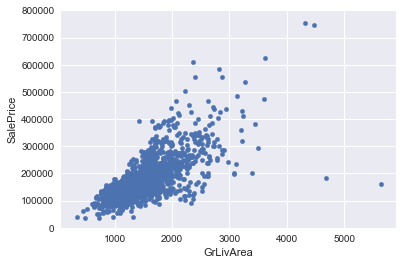

In [21]:
# 标准化后可以看到，低范围的值都在0附近，但是高范围的值就偏离0有些远了

# 多变量分析
# GrLivArea和SalePrice
data = pd.concat([train_data['SalePrice'], train_data['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0, 800000))

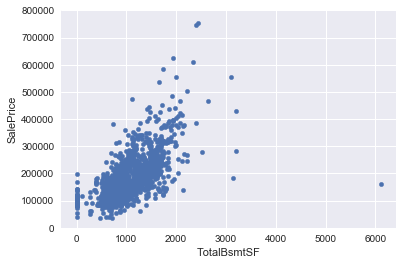

In [22]:
# TotalBsmtSF和SalePrice
data = pd.concat([train_data['SalePrice'], train_data['TotalBsmtSF']], axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice', ylim=(0, 800000))

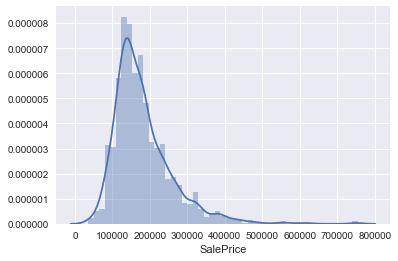

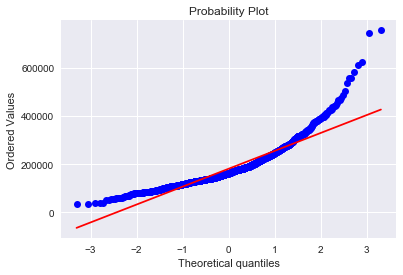

In [23]:
# 正态性
# 绘制SalePrice直方图和正态概率图

from scipy import stats
def dist_prob(data):
    sns.distplot(data)
    fig = plt.figure()
    stats.probplot(data, plot=plt) # 生成样本概率图，选择plot为最佳拟合线
    # 横轴为理论分位数公式，Filliben估计
    #         0.5**(1/n),                  for i = n
    #   val = (i - 0.3175) / (n + 0.365),  for i = 2, ..., n-1
    #         1 - 0.5**(1/n),              for i = 1
    
dist_prob(train_data['SalePrice'])

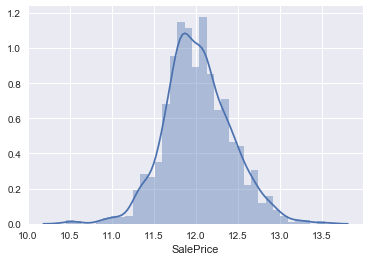

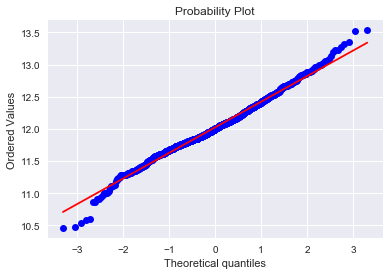

In [24]:
# 可见房价分布不是正态的，显示了峰值，正偏度，但是并不跟随对角线

# 进行对数变换
train_data['SalePrice'] = np.log(train_data['SalePrice'])
# 变换后的直方图和正态分布
dist_prob(train_data['SalePrice'])

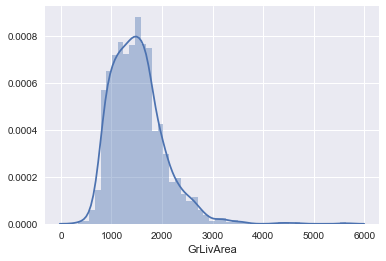

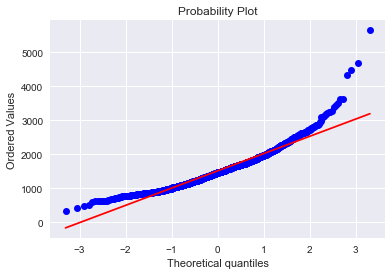

In [25]:
# 绘制GrLivArea直方图和正态概率图

dist_prob(train_data['GrLivArea'])

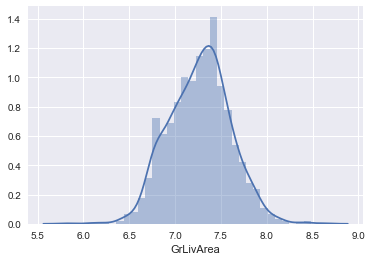

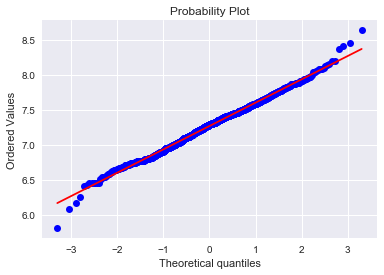

In [26]:
# 进行对数变换

train_data['GrLivArea'] = np.log(train_data['GrLivArea'])
dist_prob(train_data['GrLivArea'])

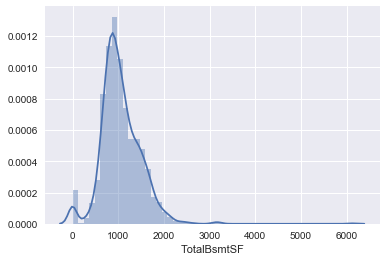

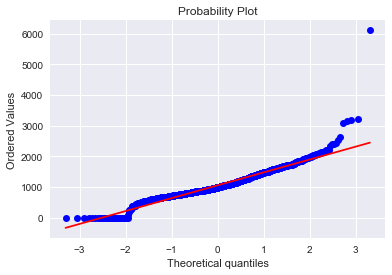

In [27]:
# 绘制GrLivArea直方图和正态概率图

dist_prob(train_data['TotalBsmtSF'])

In [28]:
# 可以看到，有大量为0的观测值
# 新建一列，包含TotalBsmtSF是否为0信息

train_data['HasBsmt'] = pd.Series(0, index=train_data.index)
train_data['HasBsmt'].loc[train_data['TotalBsmtSF']>0] = 1

In [47]:
# 只对非0值进行对数变换

index1 = train_data[train_data['HasBsmt']==1].index # 取出TotalBsmtSF特征为1的数据的索引

train_data['TotalBsmtSF2'] = train_data['TotalBsmtSF']

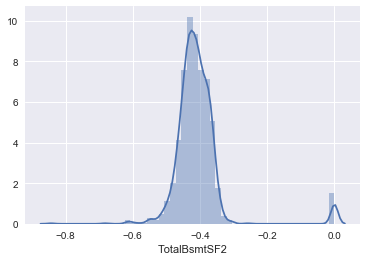

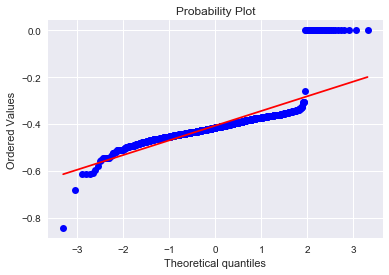

In [54]:
train_data['TotalBsmtSF2'].loc[index1] = np.log(train_data['TotalBsmtSF2'].loc[index1]) # 进行对数变化

dist_prob(train_data['TotalBsmtSF2']) # 绘制直方图和正态概率图

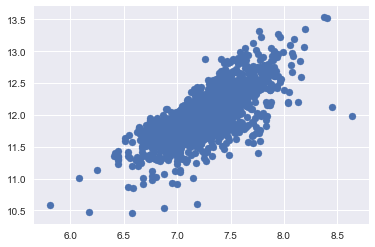

In [51]:
# 同方差性
plt.scatter(train_data['GrLivArea'], train_data['SalePrice'])

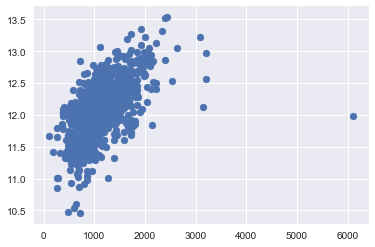

In [53]:
plt.scatter(train_data[train_data['TotalBsmtSF']>0]['TotalBsmtSF'], train_data[train_data['TotalBsmtSF']>0]['SalePrice'])